In [1]:
from common import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.covariance import EmpiricalCovariance

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

from baseTagger import *

%matplotlib inline

In [2]:
def get_csv(orifilename, outfilename, forceRedo = False):
    if not os.path.isfile(outfilename) or forceRedo:
        if not os.path.isfile(orifilename):
            print('orifilename : {} does not exist!'.format(orifilename))
            sys.exit(1)        
        df_ori = pd.read_csv(orifilename, compression='gzip')
        df = df_ori[(df_ori['cand_dRMax']<1.5) & (df_ori['cand_m']>100) & (df_ori['cand_m']<250)]
        to_drop = [x for x in df_ori.columns if 'Unnamed' in x]
        df = df.drop(to_drop, axis=1)
        df.to_csv(outfilename)
    else:
        df = pd.read_csv(outfilename)
        to_drop = [x for x in df.columns if 'Unnamed' in x]
        df = df.drop(to_drop, axis=1)
    return df

In [3]:
df = get_csv('training.csv', 'dRMax_LE_1p5_m_in_100_250_training.csv')

In [4]:
nSig = df[df['answer']==1].count().iloc[0]
nBkg = df[df['answer']==0].count().iloc[0]
weight = nSig/nBkg
df.loc[df['answer']==0, 'weight'] *= weight

In [5]:
df_shuffled = df.reindex(np.random.permutation(df.index))

In [6]:
npyInputData = np.array(df_shuffled.ix[:, :'j3_QGL'])
npyInputAnswer = np.array(df_shuffled.ix[:, 'answer'])
npyInputWgts = np.array(df_shuffled.ix[:, 'weight'])

In [7]:
clf = RandomForestClassifier(n_estimators=100, max_depth=14, n_jobs=4)
clf = clf.fit(npyInputData, npyInputAnswer, npyInputWgts)

In [8]:
fileObject = open("TrainingOutput.pkl",'wb')
out = pickle.dump(clf, fileObject)
fileObject.close()

In [9]:
listToGet = df_shuffled.columns[:df_shuffled.columns.get_loc('j3_QGL')+1]
feature_importance = clf.feature_importances_
feature_names = np.array(listToGet)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

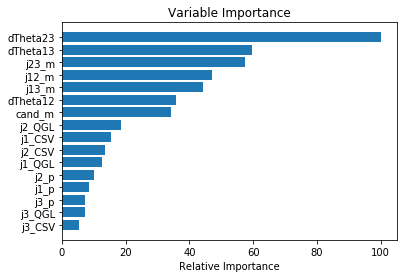

In [10]:
pos = np.arange(sorted_idx.shape[0]) + .5
_ = plt.barh(pos, feature_importance[sorted_idx], align='center')
_ = plt.yticks(pos, feature_names[sorted_idx])
_ = plt.xlabel('Relative Importance')
_ = plt.title('Variable Importance')

In [11]:
featureImportanceandNames = list(zip(feature_names, feature_importance))
print([featureImportanceandNames[a] for a in sorted_idx])

[('j3_CSV', 5.2361612291218238), ('j3_QGL', 7.1919944382862919), ('j3_p', 7.3714231941748452), ('j1_p', 8.5980476995999506), ('j2_p', 10.116113601880686), ('j1_QGL', 12.578177128891067), ('j2_CSV', 13.457314438922971), ('j1_CSV', 15.522010128675978), ('j2_QGL', 18.673110343276083), ('cand_m', 34.29322577016827), ('dTheta12', 35.661683037785977), ('j13_m', 44.342294171110666), ('j12_m', 47.080928190680496), ('j23_m', 57.429146009638721), ('dTheta13', 59.543854012570243), ('dTheta23', 100.0)]


In [12]:
val_df = get_csv('validation.csv', 'dRMax_LE_1p5_m_in_100_250_validation.csv')
val_npInputList = np.array(val_df.ix[:, :'j3_QGL'])
val_npInputAnswers = np.array(val_df.ix[:, 'answer'])
val_npInputList_ttbar = np.array(val_df[val_df['procTypes']=='ttbar'].ix[:, :'j3_QGL'])
val_npInputAnswers_ttbar = np.array(val_df[val_df['procTypes']=='ttbar'].ix[:, 'answer'])
val_npInputList_zinv = np.array(val_df[val_df['procTypes']=='zinv'].ix[:, :'j3_QGL'])
val_npInputAnswers_zinv = np.array(val_df[val_df['procTypes']=='zinv'].ix[:, 'answer'])
val_slimNpData0_ttbar = val_npInputList_ttbar[val_npInputAnswers_ttbar==0]
val_slimNpData1_ttbar = val_npInputList_ttbar[val_npInputAnswers_ttbar==1]
val_slimNpData_zinv = val_npInputList_zinv[val_npInputAnswers_zinv==0]

In [13]:
val_output = clf.predict_proba(val_npInputList)[:,1]
val_df['disc'] = val_output

In [14]:
from scipy.linalg import fractional_matrix_power
def diagElements(m):
    size = m.shape[0]
    return np.matrix(np.diag([m[i, i] for i in range(size)]))

def corrMat(m):
    sqrt_diag = fractional_matrix_power(diagElements(m), -0.5)
    return np.array(sqrt_diag * m  * sqrt_diag)

In [15]:
ecv = EmpiricalCovariance()
_=ecv.fit(val_slimNpData0_ttbar)
corr0_ttbar = corrMat(np.matrix(ecv.covariance_))
_=ecv.fit(val_slimNpData1_ttbar)
corr1_ttbar = corrMat(np.matrix(ecv.covariance_))
_=ecv.fit(val_slimNpData_zinv)
corr_zinv = corrMat(np.matrix(ecv.covariance_))

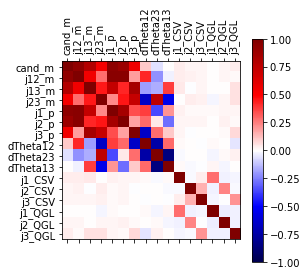

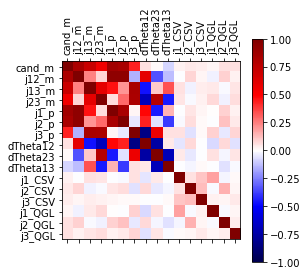

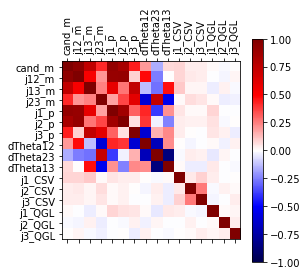

In [16]:
_=plt.matshow(corr0_ttbar, cmap=plt.cm.seismic, vmin = -1, vmax = 1)
_=plt.xticks(range(len(listToGet)), listToGet, rotation='vertical')
_=plt.yticks(range(len(listToGet)), listToGet)
_=plt.colorbar(orientation='vertical')
plt.savefig("feature_corrolation_ttbar_nomatch.png")

_=plt.matshow(corr1_ttbar, cmap=plt.cm.seismic, vmin = -1, vmax = 1)
_=plt.xticks(range(len(listToGet)), listToGet, rotation='vertical')
_=plt.yticks(range(len(listToGet)), listToGet)
_=plt.colorbar(orientation='vertical')
plt.savefig("feature_corrolation_ttbar_match.png")

_=plt.matshow(corr_zinv, cmap=plt.cm.seismic, vmin = -1, vmax = 1)
_=plt.xticks(range(len(listToGet)), listToGet, rotation='vertical')
_=plt.yticks(range(len(listToGet)), listToGet)
_=plt.colorbar(orientation='vertical')
plt.savefig("feature_corrolation_Znunu.png")

In [17]:
val_df['passBaseTagger'] = val_df.apply(baseTaggerReqs, axis=1)

In [18]:
sr_cuts = (val_df['Njet']>=4) & (val_df['MET']>200) & (val_df['cand_dRMax']<1.5)
baseTagger_fpr_tpr = val_df[sr_cuts].groupby(by=['answer', 'passBaseTagger'])['sampleWgt'].sum()
baseTagger_fpr_tpr
tp_base = baseTagger_fpr_tpr.loc[1, True]
fp_base = baseTagger_fpr_tpr.loc[0, True]
tn_base = baseTagger_fpr_tpr.loc[0, False]
fn_base = baseTagger_fpr_tpr.loc[1, False]
tpr_base = tp_base/(tp_base + fn_base)
fpr_base = fp_base/(fp_base + tn_base)

precision_base = tp_base/(tp_base + fp_base)
recall_base = tp_base/(tp_base + fn_base)

fscore_base = 2*precision_base*recall_base/(precision_base+recall_base)

fpr_base, tpr_base, precision_base, recall_base, fscore_base

answer  passBaseTagger
0       False              65868.476752
        True              128094.882087
1       False               3069.385830
        True               19059.424391
Name: sampleWgt, dtype: float64

(0.66040762984059254,
 0.86129458388375169,
 0.12951999059360264,
 0.86129458388375169,
 0.22517808937517617)

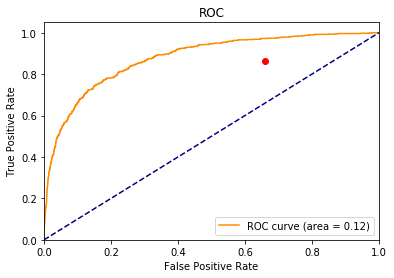

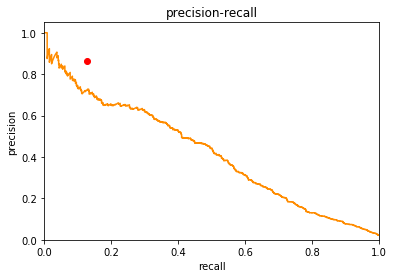

baseTagger tpr : 0.8612945838837517  fpr : 0.6604076298405925  fscore : 0.22517808937517617 --> precision : 0.12951999059360264  recall : 0.8612945838837517
mva (same_tpr) tpr : 0.8612945838837568  fpr : 0.29871321189729416  cut : 0.5067677580491232
mva (same_fpr) tpr : 0.9722589167767514  fpr : 0.6604478231278436  cut : 0.09184832906060197
mva (same_fscore) fscore : 0.22519509476031216  precision : 0.7214285714285714  recall : 0.1334214002642008  cut : 0.9904062663750166
mva (max_fscore) fscore : 0.4722921914357682  precision : 0.45126353790613716  recall : 0.4953764861294584  cut : 0.9515311214590372


In [19]:
val_npInputAnswers_sel = val_npInputAnswers[np.array(sr_cuts)]
val_output_sel = val_output[np.array(sr_cuts)]

precision, recall, thresholds_pr = precision_recall_curve(val_npInputAnswers_sel, val_output_sel)
fscore = 2*precision*recall/(precision + recall)
average_precision = average_precision_score(val_npInputAnswers_sel, val_output_sel)
fpr, tpr, thresholds_roc = roc_curve(val_npInputAnswers_sel, val_output_sel, sample_weight=np.array(val_df.loc[sr_cuts,'sampleWgt']))
roc_auc = auc(tpr, fpr)
_ = plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC curve (area = %0.2f)'%roc_auc)
_ = plt.plot([0, 1], [0, 1], color='navy', linestyle = '--')
_ = plt.xlim([0.0, 1.0])
_ = plt.ylim([0.0, 1.05])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC')
_ = plt.legend(loc='lower right')
_ = plt.plot(fpr_base, tpr_base, 'or')
plt.show()
_=plt.plot(recall, precision, color = 'darkorange')
_=plt.xlim([0.0, 1.0])
_=plt.ylim([0.0, 1.05])
_=plt.xlabel('recall')
_=plt.ylabel('precision')
_=plt.title('precision-recall')
_=plt.plot(precision_base, recall_base, 'or')
plt.show()
# Get the cut value for where we have same tpr as the tpr_base
idx_same_tpr = -1
idx_same_fpr = -1
for i in range(len(fpr)-1):
    if(tpr[i]<tpr_base and tpr[i+1]>=tpr_base):
        idx_same_tpr = i+1
    if(fpr[i]<fpr_base and fpr[i+1]>=fpr_base):
        idx_same_fpr = i+1
idx_same_fscore = -1
idx_max_fscore = -1
for i in range(len(fscore)-1):
    if(fscore[i]<fscore_base and fscore[i+1]>=fscore_base):
        idx_same_fscore = i+1
    if idx_max_fscore == -1 or (fscore[idx_max_fscore]<fscore[i]):
        idx_max_fscore = i
# We want a high recall (tpr) working point (as high as the base tagger)
mva_cut = thresholds_roc[idx_same_tpr]
alt_mva_cut = thresholds_roc[idx_same_fpr]
print('baseTagger tpr : {}  fpr : {}  fscore : {} --> precision : {}  recall : {}'.format(tpr_base, fpr_base, fscore_base, precision_base, recall_base))
print('mva (same_tpr) tpr : {}  fpr : {}  cut : {}'.format(tpr[idx_same_tpr], fpr[idx_same_tpr], mva_cut))
print('mva (same_fpr) tpr : {}  fpr : {}  cut : {}'.format(tpr[idx_same_fpr], fpr[idx_same_fpr], alt_mva_cut))
print('mva (same_fscore) fscore : {}  precision : {}  recall : {}  cut : {}'.format(fscore[idx_same_fscore], precision[idx_same_fscore], recall[idx_same_fscore], thresholds_pr[idx_same_fscore]))
print('mva (max_fscore) fscore : {}  precision : {}  recall : {}  cut : {}'.format(fscore[idx_max_fscore], precision[idx_max_fscore], recall[idx_max_fscore], thresholds_pr[idx_max_fscore]))

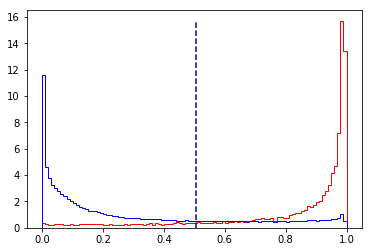

In [20]:
sig_val_output = val_output[val_npInputAnswers==1]
bkg_val_output = val_output[val_npInputAnswers==0]
y_sig, x_sig, _=plt.hist(sig_val_output, range = (0, 1.0), normed = True, color = 'red', bins = 100, histtype='step')
y_bkg, x_bkg, _=plt.hist(bkg_val_output, range = (0, 1.0), normed = True, color = 'blue', bins = 100, histtype='step')
_=plt.plot([mva_cut, mva_cut], [0, max(y_sig.max(), y_bkg.max())], color='navy', linestyle = '--')

In [21]:
grouped_val_df = val_df.groupby(['evtNum', 'procTypes'])

In [22]:
sr_grouped_baseTagger = grouped_val_df.apply(resolveOverlapHEP)
df_grouped_baseTagger = sr_grouped_baseTagger.reset_index()
df_grouped_baseTagger =df_grouped_baseTagger.rename(columns={0:'baseTagger'})
val_df_baseTagger = pd.merge(val_df, df_grouped_baseTagger, how='outer', left_on = ['evtNum', 'procTypes'], 
         right_on = ['evtNum', 'procTypes'])
val_df_baseTagger.index = val_df.index
sr_grouped_mvaTagger = grouped_val_df.apply(resolveOverlap, mva_cut)
df_grouped_mvaTagger = sr_grouped_mvaTagger.reset_index()
df_grouped_mvaTagger = df_grouped_mvaTagger.rename(columns={0:'mvaTagger'})
val_df_taggers = pd.merge(val_df_baseTagger, df_grouped_mvaTagger, 
                                          how='outer', left_on=['evtNum', 'procTypes'],
                                         right_on=['evtNum', 'procTypes'])
val_df_taggers.index = val_df.index

In [23]:
val_df_taggers.head()

,cand_m,j12_m,j13_m,j23_m,j1_p,j2_p,j3_p,dTheta12,dTheta23,dTheta13,...,procTypes,evtNum,MET,Njet,Bjet,sampleWgt,disc,passBaseTagger,baseTagger,mvaTagger
0,170.889643,117.132308,89.360911,90.255910,60.768501,59.667680,45.119558,2.373794,1.932072,1.977319,...,ttbar,1,41.443445,5,1,29.232246,0.989453,True,[<baseTagger.simpleTopCandHEP object at 0x105d...,[<baseTagger.simpleTopCand object at 0x12dab3b...
1,207.881769,166.500611,113.792454,58.568288,93.711212,72.059351,37.017274,2.774157,1.141826,2.367203,...,ttbar,1,41.443445,5,1,29.232246,0.000885,True,[<baseTagger.simpleTopCandHEP object at 0x105d...,[<baseTagger.simpleTopCand object at 0x12dab3b...
2,168.919911,121.223590,104.941329,54.473935,75.551056,51.357779,40.668776,2.610579,1.224871,2.447735,...,ttbar,2,55.017690,9,2,29.232246,0.205933,False,[<baseTagger.simpleTopCandHEP object at 0x105d...,[<baseTagger.simpleTopCand object at 0x12dab3d...
3,178.553501,135.950812,102.983519,54.473935,80.739760,59.156055,37.185479,2.699864,1.189609,2.393711,...,ttbar,2,55.017690,9,2,29.232246,0.117083,True,[<baseTagger.simpleTopCandHEP object at 0x105d...,[<baseTagger.simpleTopCand object at 0x12dab3d...
4,203.124755,147.022776,125.301280,65.782914,90.681535,61.717518,47.625345,2.630705,1.197125,2.455355,...,ttbar,2,55.017690,9,2,29.232246,0.008660,False,[<baseTagger.simpleTopCandHEP object at 0x105d...,[<baseTagger.simpleTopCand object at 0x12dab3d...
